Copyright 2022 Andrew M. Olney and made available under [CC BY-SA](https://creativecommons.org/licenses/by-sa/4.0) for text and [Apache-2.0](http://www.apache.org/licenses/LICENSE-2.0) for code.


# Random forests

### What you will learn

Random forests are one of the most popular models in modern day data science and machine learning.
They combine decision trees with two new ideas:

- Random sampling of data 
- Random sampling of features

### When to use random forests

Random forests can be used in the same contexts as decision trees, namely when the relationship between the predictor variables and outcome is not additive.
Like decision trees, random forests can be used for classification or regression and are relatively fast.
While random forests generally have better performance than decision trees, the performance comes at a cost of fuzzier relationships between predictors.

## Random sampling of data

As we've seen, decision trees tend to overfit if we don't limit how large they can grow.
We can *regularize* the tree by applying a penalty to trees based on their size and fit.
Or we can simply restrict how large we'll allow trees to get, regardless of fit.

There is another way to deal with the overfitting problem that may surprise you - don't deal with it!
Instead of trying to make a single perfect tree, this approach is to make lots of imperfect trees, a **forest**.
It turns out that if we average the predictions of a lot of imperfect trees, we can get a prediction that is as good, or better, than a single perfect tree.
But there's a catch: this only works if the imperfect trees are *different* from each other.
Obviously, if they were all the same, then averaging them would give the same prediction as any one of them.

Random sampling of the data is one way we can ensure the trees in our forest are different from each other.
Every time we want to make a tree, we sample just part of our data and build a tree with that.
Because every sample is random, our trees will be different from each other.
This kind of sampling is called **bootstrapping**, which is just a funny way of saying that we are sampling *with replacement*.
An example of bootstrapping 10 cards from a deck of cards would be to shuffle the deck, draw 10 cards off the top, "use" them, and then put them back in the deck ("replace" them).

If we bootstrap a forest of trees, and then average (or combine) their predictions, this is called **bootstrap aggregating**, or **bagging** for short.
Don't worry if you find these names really strange, because you're not alone!
As an example of aggregation, suppose I have 100 trees in my forest, and I ask all of them to predict if someone has a disease or not (a binary classification task).
If 51 of them say `Positive` and 49 say `Negative`, then the majority are `Positive` and that is the prediction of the forest as a whole.
Another example would be a regression task, where each tree in the forest predicts the fuel economy (mpg) of a car based on its engine, weight, etc.
In that case, each regression tree in the forest would predict a numeric mpg, and these would be averaged to get the prediction of the forest as a whole.

## Bagging example

Bagging by itself is a data science technique, so we can try it out by itself before moving on to random forests.

If we were to do bagging from scratch, you might imagine we'd have a loop where each time we sampled some rows from a data frame, built a classifier, and then saved the classifier in a list.
Then when we wanted to classify something, we'd run it through each classifier in the list to get the predictions, and then we'd average those to get the final prediction.

Fortunately for us, `parsnip` takes care of all of those steps for us.

### Load data

Let's look at some breast cancer diagnostic data, which consists of the following variables as mean, standard error, and "worst" (mean of three largest variables) collected by digital imagery of a biopsy.

| Variable | Type | Description |
|:-------|:-------|:-------|
|radius | Ratio | mean of distances from center to points on the perimeter|
|texture | Ratio | standard deviation of gray-scale values|
|perimeter | Ratio | perimeter of cancer|
|area | Ratio | area of cancer|
|smoothness | Ratio | local variation in radius lengths|
|compactness | Ratio |  perimeter^2 / area - 1.0|
|concavity | Ratio |  severity of concave portions of the contour|
|concave points | Ratio |  number of concave portions of the contour|
|symmetry | Ratio | symmetry of cancer|
|fractal dimension | Ratio | "coastline approximation" - 1|
| class | Nominal (binary) | malignant (1) or benign (0)

<div style="text-align:center;font-size: smaller">
    <b>Source:</b> This dataset was taken from the UCI Machine Learning Repository library.
</div>
<br>

The goal is to predict the presence/absence of cancer.

Start by loading `readr`, `dplyr`, `base`, and `tidyr` so we can read data into a dataframe and manipulate it:

- `library readr`
- `library dplyr`
- `library base`
- `library tidyr`

In [36]:
library(readr)
library(dplyr)
library(tidyr)
library(base)

#<xml xmlns="https://developers.google.com/blockly/xml"><variables><variable id="_;PP-/]_2fNUR.dyhw(8">readr</variable><variable id="`IEAx*Bh}E,Y}mK;jr;{">dplyr</variable><variable id="%ovw[;dNkqx,|V0M/RZA">tidyr</variable><variable id="6C!l+@S8,SvtzakmsxQD">base</variable></variables><block type="import_R" id="q]np1Ju|B`4k*R-zylwU" x="44" y="66"><field name="libraryName" id="_;PP-/]_2fNUR.dyhw(8">readr</field><next><block type="import_R" id="(%@0XC,((6M%4]kj+iDm"><field name="libraryName" id="`IEAx*Bh}E,Y}mK;jr;{">dplyr</field><next><block type="import_R" id="O3DD!zZI|R.~Qt#T:6en"><field name="libraryName" id="%ovw[;dNkqx,|V0M/RZA">tidyr</field><next><block type="import_R" id="FvLju.H}3LaRwg}ooK5W"><field name="libraryName" id="6C!l+@S8,SvtzakmsxQD">base</field></block></next></block></next></block></next></block></xml>

Read the data into a dataframe, specifying `Target` as a factor:
    
- Set `dataframe` to `with readr do read_csv`
    - using `"datasets/cancer.csv"`
    - and `col_types =` `create list with` `Target = col_factor(c("1", "0"))`
- `dataframe` (to display)

In [38]:
dataframe = readr::read_csv("datasets/cancer.csv",col_types= list(Target = col_factor(c("1", "0"))))

dataframe

#<xml xmlns="https://developers.google.com/blockly/xml"><variables><variable id="(*,(U(rm+VG0+vg;w$65">dataframe</variable><variable id="_;PP-/]_2fNUR.dyhw(8">readr</variable></variables><block type="variables_set" id="gM*jw`FfIR3)8=g0iEB7" x="28" y="220"><field name="VAR" id="(*,(U(rm+VG0+vg;w$65">dataframe</field><value name="VALUE"><block type="varDoMethod_R" id=",vaW{t?FHN1~E?+,h!w-"><mutation items="2"></mutation><field name="VAR" id="_;PP-/]_2fNUR.dyhw(8">readr</field><field name="MEMBER">read_csv</field><data>readr:read_csv</data><value name="ADD0"><block type="text" id="dfrpI5b@DHr+DQ:|@vpv"><field name="TEXT">datasets/cancer.csv</field></block></value><value name="ADD1"><block type="valueOutputCodeBlock_R" id="3;qKsZV3(`u?k`45kqG)"><field name="CODE">col_types=</field><value name="INPUT"><block type="lists_create_with" id="9~@6,ZyS4jo]S4/~qWl@"><mutation items="1"></mutation><value name="ADD0"><block type="dummyOutputCodeBlock_R" id=":|!@n#mItKK)!B:!r2?@"><field name="CODE">Target = col_factor(c("1", "0"))</field></block></value></block></value></block></value></block></value></block><block type="variables_get" id="dn{+Q#DO%lN;G_tFGJ#B" x="8" y="304"><field name="VAR" id="(*,(U(rm+VG0+vg;w$65">dataframe</field></block></xml>

mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,radius error,texture error,perimeter error,area error,smoothness error,compactness error,concavity error,concave points error,symmetry error,fractal dimension error,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,Target
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,1.0950,0.9053,8.589,153.40,0.006399,0.04904,0.05373,0.01587,0.03003,0.006193,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,0
20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,0.5435,0.7339,3.398,74.08,0.005225,0.01308,0.01860,0.01340,0.01389,0.003532,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,0
19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,0.7456,0.7869,4.585,94.03,0.006150,0.04006,0.03832,0.02058,0.02250,0.004571,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,0
11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,0.4956,1.1560,3.445,27.23,0.009110,0.07458,0.05661,0.01867,0.05963,0.009208,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,0
20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,0.7572,0.7813,5.438,94.44,0.011490,0.02461,0.05688,0.01885,0.01756,0.005115,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,0
12.45,15.70,82.57,477.1,0.12780,0.17000,0.1578,0.08089,0.2087,0.07613,0.3345,0.8902,2.217,27.19,0.007510,0.03345,0.03672,0.01137,0.02165,0.005082,15.47,23.75,103.40,741.6,0.1791,0.5249,0.5355,0.1741,0.3985,0.12440,0
18.25,19.98,119.60,1040.0,0.09463,0.10900,0.1127,0.07400,0.1794,0.05742,0.4467,0.7732,3.180,53.91,0.004314,0.01382,0.02254,0.01039,0.01369,0.002179,22.88,27.66,153.20,1606.0,0.1442,0.2576,0.3784,0.1932,0.3063,0.08368,0
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
15.22,30.62,103.40,716.9,0.10480,0.20870,0.25500,0.09429,0.2128,0.07152,0.2602,1.205,2.362,22.65,0.004625,0.04844,0.07359,0.01608,0.02137,0.006142,17.520,42.79,128.70,915.0,0.14170,0.79170,1.1700,0.2356,0.4089,0.14090,0


We can use `base::summary` to check for NA:

- with `base` do `summary`
    - using `dataframe`

In [39]:
base::summary(dataframe)

#<xml xmlns="https://developers.google.com/blockly/xml"><variables><variable id="6C!l+@S8,SvtzakmsxQD">base</variable><variable id="(*,(U(rm+VG0+vg;w$65">dataframe</variable></variables><block type="varDoMethod_R" id="m@Xch_T9K6?ztoHR*.iM" x="-235" y="107"><mutation items="1"></mutation><field name="VAR" id="6C!l+@S8,SvtzakmsxQD">base</field><field name="MEMBER">summary</field><data>base:summary</data><value name="ADD0"><block type="variables_get" id="[D8t%vfNoa06}[{Z#ZG%"><field name="VAR" id="(*,(U(rm+VG0+vg;w$65">dataframe</field></block></value></block></xml>

  mean radius      mean texture   mean perimeter     mean area     
 Min.   : 6.981   Min.   : 9.71   Min.   : 43.79   Min.   : 143.5  
 1st Qu.:11.700   1st Qu.:16.17   1st Qu.: 75.17   1st Qu.: 420.3  
 Median :13.370   Median :18.84   Median : 86.24   Median : 551.1  
 Mean   :14.127   Mean   :19.29   Mean   : 91.97   Mean   : 654.9  
 3rd Qu.:15.780   3rd Qu.:21.80   3rd Qu.:104.10   3rd Qu.: 782.7  
 Max.   :28.110   Max.   :39.28   Max.   :188.50   Max.   :2501.0  
                                                                   
 mean smoothness   mean compactness  mean concavity     mean concave points
 Min.   :0.05263   Min.   :0.01938   Min.   :0.000692   Min.   :0.001852   
 1st Qu.:0.08637   1st Qu.:0.06492   1st Qu.:0.030880   1st Qu.:0.020895   
 Median :0.09587   Median :0.09263   Median :0.064905   Median :0.034840   
 Mean   :0.09636   Mean   :0.10434   Mean   :0.090876   Mean   :0.050063   
 3rd Qu.:0.10530   3rd Qu.:0.13040   3rd Qu.:0.132325   3rd Qu.:0.074842   


We see various NAs.
We could explore this further, but since it looks like there are probably 13 defective rows out of > 500, let's just drop them:

- Set `dataframe` to with `tidyr` do `drop_na`
    - using `dataframe`

In [40]:
dataframe = tidyr::drop_na(dataframe)

#<xml xmlns="https://developers.google.com/blockly/xml"><variables><variable id="(*,(U(rm+VG0+vg;w$65">dataframe</variable><variable id="%ovw[;dNkqx,|V0M/RZA">tidyr</variable></variables><block type="variables_set" id="vS#B4_mcJ!y=[aT4^GLl" x="-101" y="90"><field name="VAR" id="(*,(U(rm+VG0+vg;w$65">dataframe</field><value name="VALUE"><block type="varDoMethod_R" id="v!4J0b_OO4#tJHH1nM5w"><mutation items="1"></mutation><field name="VAR" id="%ovw[;dNkqx,|V0M/RZA">tidyr</field><field name="MEMBER">drop_na</field><data>tidyr:drop_na</data><value name="ADD0"><block type="variables_get" id="v8@n0MMCWY0yHilDF^(J"><field name="VAR" id="(*,(U(rm+VG0+vg;w$65">dataframe</field></block></value></block></value></block></xml>

We also need to do something about our variable names.
Some of the models we will use can't handle variable names that have spaces in them, so we need to fix that:

- `colnames(dataframe) <- make.names(colnames(dataframe))` (as a freestyle)

- `dataframe` (to display)

In [41]:
colnames(dataframe) <- make.names(colnames(dataframe))

dataframe

#<xml xmlns="https://developers.google.com/blockly/xml"><variables><variable id="(*,(U(rm+VG0+vg;w$65">dataframe</variable></variables><block type="dummyOutputCodeBlock_R" id="JojKFgJBT_FqgplnfuE@" x="-227" y="-59"><field name="CODE">colnames(dataframe) &lt;- make.names(colnames(dataframe))</field></block><block type="variables_get" id="p5Vu^n*kNY/YfAIk_|#0" x="-234" y="22"><field name="VAR" id="(*,(U(rm+VG0+vg;w$65">dataframe</field></block></xml>

mean.radius,mean.texture,mean.perimeter,mean.area,mean.smoothness,mean.compactness,mean.concavity,mean.concave.points,mean.symmetry,mean.fractal.dimension,radius.error,texture.error,perimeter.error,area.error,smoothness.error,compactness.error,concavity.error,concave.points.error,symmetry.error,fractal.dimension.error,worst.radius,worst.texture,worst.perimeter,worst.area,worst.smoothness,worst.compactness,worst.concavity,worst.concave.points,worst.symmetry,worst.fractal.dimension,Target
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,1.0950,0.9053,8.589,153.40,0.006399,0.04904,0.05373,0.01587,0.03003,0.006193,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,0
20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,0.5435,0.7339,3.398,74.08,0.005225,0.01308,0.01860,0.01340,0.01389,0.003532,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,0
19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,0.7456,0.7869,4.585,94.03,0.006150,0.04006,0.03832,0.02058,0.02250,0.004571,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,0
11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,0.4956,1.1560,3.445,27.23,0.009110,0.07458,0.05661,0.01867,0.05963,0.009208,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,0
20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,0.7572,0.7813,5.438,94.44,0.011490,0.02461,0.05688,0.01885,0.01756,0.005115,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,0
12.45,15.70,82.57,477.1,0.12780,0.17000,0.1578,0.08089,0.2087,0.07613,0.3345,0.8902,2.217,27.19,0.007510,0.03345,0.03672,0.01137,0.02165,0.005082,15.47,23.75,103.40,741.6,0.1791,0.5249,0.5355,0.1741,0.3985,0.12440,0
18.25,19.98,119.60,1040.0,0.09463,0.10900,0.1127,0.07400,0.1794,0.05742,0.4467,0.7732,3.180,53.91,0.004314,0.01382,0.02254,0.01039,0.01369,0.002179,22.88,27.66,153.20,1606.0,0.1442,0.2576,0.3784,0.1932,0.3063,0.08368,0
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
14.05,27.15,91.38,600.4,0.09929,0.1126,0.04462,0.04304,0.1537,0.06171,0.3645,1.492,2.888,29.84,0.007256,0.02678,0.02071,0.01626,0.02080,0.005304,15.30,33.17,100.2,706.7,0.1241,0.2264,0.1326,0.1048,0.2250,0.08321,1


We've looked at this data before, so we'll skip the exploration steps we normally do, like correlations and plotting.

### Model

Load the model packages `parsnip` and `generics`.
Let's also set a random seed so our results match:

- `library parsnip`
- `library generics`
- with `base` do `set.seed` using `2`

In [70]:
library(parsnip)
library(generics)

base::set.seed(2)

#<xml xmlns="https://developers.google.com/blockly/xml"><variables><variable id="3q]Js%*Alzd]|p|FOe}-">parsnip</variable><variable id="6C!l+@S8,SvtzakmsxQD">base</variable><variable id="w(9-o9gLSDEJ,]Qt}e!^">generics</variable></variables><block type="import_R" id=")EO_9d*-V8f05GJ8VFM#" x="-219" y="-33"><field name="libraryName" id="3q]Js%*Alzd]|p|FOe}-">parsnip</field><next><block type="import_R" id="ygSk4mB:k;Qj4sN*DQ8k"><field name="libraryName" id="w(9-o9gLSDEJ,]Qt}e!^">generics</field></block></next></block><block type="varDoMethod_R" id=")}r0N8#cHS1qK@gaGTu_" x="-189" y="78"><mutation items="1"></mutation><field name="VAR" id="6C!l+@S8,SvtzakmsxQD">base</field><field name="MEMBER">set.seed</field><data>base:set.seed</data><value name="ADD0"><block type="math_number" id="+)R.sl~$F(BgZkNKC+Q9"><field name="NUM">2</field></block></value></block></xml>

Now we can create and fit the bagging classifier.
We'll do this simply, without a workflow:

- Set `model_bagging` to 
    - `pipe` 
        - with `parsnip` do `rand_forest` 
            - using `mtry = .preds()`
    - to with `parsnip` do `set_mode`
        - using `"classification"`
    - then to with `parsnip` do `set_engine`
        - using `"ranger"`
        - and `importance = "impurity"`
    - then to with `parsnip` do `fit.model_spec`
        - using `Target ~ .`
        - and `data = dataframe`
        
**Although the model is `rand_forest`, `mtry = .preds()` makes it bag decision trees because `mtry = .preds()` forces use of all predictors.** 

In [86]:
model_bagging = parsnip::rand_forest(mtry = .preds()) %>%
    parsnip::set_mode("classification") %>%
    parsnip::set_engine("ranger",importance = "impurity") %>%
    parsnip::fit.model_spec(Target ~ .,data = dataframe)

#<xml xmlns="https://developers.google.com/blockly/xml"><variables><variable id="5O|IyN_@D5)6c==27EAK">model_bagging</variable><variable id="3q]Js%*Alzd]|p|FOe}-">parsnip</variable></variables><block type="variables_set" id="*(u89h_-M@(PB-!qP/1l" x="-94" y="176"><field name="VAR" id="5O|IyN_@D5)6c==27EAK">model_bagging</field><value name="VALUE"><block type="pipe_R" id="Oj1:/l+xksT^dSM;w{,g"><mutation items="3"></mutation><value name="INPUT"><block type="varDoMethod_R" id="m!?PwvZD%AJHhH1paJ[8"><mutation items="1"></mutation><field name="VAR" id="3q]Js%*Alzd]|p|FOe}-">parsnip</field><field name="MEMBER">rand_forest</field><data>parsnip:rand_forest</data><value name="ADD0"><block type="dummyOutputCodeBlock_R" id="pxup-Zh`{GwY*{F|yO$|"><field name="CODE">mtry = .preds()</field></block></value></block></value><value name="ADD0"><block type="varDoMethod_R" id="ady`8N}J*2BV_*AmtF`n"><mutation items="1"></mutation><field name="VAR" id="3q]Js%*Alzd]|p|FOe}-">parsnip</field><field name="MEMBER">set_mode</field><data>parsnip:set_mode</data><value name="ADD0"><block type="text" id="#4#x{=R9!%aA:_,cHnF("><field name="TEXT">classification</field></block></value></block></value><value name="ADD1"><block type="varDoMethod_R" id="bybPF(gahfhB3cmyy;/n"><mutation items="2"></mutation><field name="VAR" id="3q]Js%*Alzd]|p|FOe}-">parsnip</field><field name="MEMBER">set_engine</field><data>parsnip:set_engine</data><value name="ADD0"><block type="text" id="v9=Ry*6UUQjzFr5Sy@,f"><field name="TEXT">ranger</field></block></value><value name="ADD1"><block type="dummyOutputCodeBlock_R" id="!2E_rDb~`ll+Rj3OIABb"><field name="CODE">importance = "impurity"</field></block></value></block></value><value name="ADD2"><block type="varDoMethod_R" id="Q61XWF.0ty]Aw^i83YUS"><mutation items="2"></mutation><field name="VAR" id="3q]Js%*Alzd]|p|FOe}-">parsnip</field><field name="MEMBER">fit.model_spec</field><data>parsnip:fit.model_spec</data><value name="ADD0"><block type="dummyOutputCodeBlock_R" id="n(du-Q]_KTwoCFj6n|V5"><field name="CODE">Target ~ .</field></block></value><value name="ADD1"><block type="dummyOutputCodeBlock_R" id="lIU{_ql0epb7NH-C6Kvw"><field name="CODE">data = dataframe</field></block></value></block></value></block></value></block></xml>

Get predictions to evaluate the model:

- Set `data_evaluation_bagging` to 
    - with `generics` do `augment`
        - using `model_bagging`
        - and `dataframe`
- `data_evaluation_bagging`

<!-- 
BRIER SCORE APPROACH
We'll add an extra step here to create a column that is an numeric version of the Target class, as we'll need this numeric version to calculate a new evaluation metric later:

- Set `data_evaluation_bagging` to 
    - `pipe`
        - with `generics` do `augment`
            - using `model_bagging`
            - and `dataframe`
    - to with `dplyr` do `mutate`
        - using `Target_num = as.numeric(levels(Target))[Target]`

- `data_evaluation_bagging`

*Note: The rather unpleasant syntax, `Target_num = as.numeric(levels(Target))[Target]`, converts a factor into  a numeric equivalent **IF** the factor has levels with numeric names. This is a useful trick, but in such cases it is sometimes better to read a file without converting the column to a factor and then create a factor version of that column later.* -->

In [87]:
data_evaluation_bagging = generics::augment(model_bagging,dataframe)

data_evaluation_bagging

#<xml xmlns="https://developers.google.com/blockly/xml"><variables><variable id="y:*F*2y{*kytcXxoGvLC">data_evaluation_bagging</variable><variable id="w(9-o9gLSDEJ,]Qt}e!^">generics</variable><variable id="5O|IyN_@D5)6c==27EAK">model_bagging</variable><variable id="(*,(U(rm+VG0+vg;w$65">dataframe</variable></variables><block type="variables_set" id="qHR/^ulVJ-n)W4{:7-@Y" x="-194" y="111"><field name="VAR" id="y:*F*2y{*kytcXxoGvLC">data_evaluation_bagging</field><value name="VALUE"><block type="varDoMethod_R" id="k:ygkKz,swERp]34_uH{"><mutation items="2"></mutation><field name="VAR" id="w(9-o9gLSDEJ,]Qt}e!^">generics</field><field name="MEMBER">augment</field><data>generics:augment</data><value name="ADD0"><block type="variables_get" id="9A!7aBLNe1]IufZ-R;BY"><field name="VAR" id="5O|IyN_@D5)6c==27EAK">model_bagging</field></block></value><value name="ADD1"><block type="variables_get" id="qPW(v;lbSJ=RJ)y;hW$)"><field name="VAR" id="(*,(U(rm+VG0+vg;w$65">dataframe</field></block></value></block></value></block><block type="variables_get" id="Um|1+kaS%|p}e=,Pw)MQ" x="-203" y="317"><field name="VAR" id="y:*F*2y{*kytcXxoGvLC">data_evaluation_bagging</field></block></xml>

mean.radius,mean.texture,mean.perimeter,mean.area,mean.smoothness,mean.compactness,mean.concavity,mean.concave.points,mean.symmetry,mean.fractal.dimension,radius.error,texture.error,perimeter.error,area.error,smoothness.error,compactness.error,concavity.error,concave.points.error,symmetry.error,fractal.dimension.error,worst.radius,worst.texture,worst.perimeter,worst.area,worst.smoothness,worst.compactness,worst.concavity,worst.concave.points,worst.symmetry,worst.fractal.dimension,Target,.pred_class,.pred_1,.pred_0
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<fct>,<dbl>,<dbl>
17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,1.0950,0.9053,8.589,153.40,0.006399,0.04904,0.05373,0.01587,0.03003,0.006193,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,0,0,0.14319206,0.8568079
20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,0.5435,0.7339,3.398,74.08,0.005225,0.01308,0.01860,0.01340,0.01389,0.003532,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,0,0,0.00620000,0.9938000
19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,0.7456,0.7869,4.585,94.03,0.006150,0.04006,0.03832,0.02058,0.02250,0.004571,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,0,0,0.00000000,1.0000000
11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,0.4956,1.1560,3.445,27.23,0.009110,0.07458,0.05661,0.01867,0.05963,0.009208,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,0,0,0.07051984,0.9294802
20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,0.7572,0.7813,5.438,94.44,0.011490,0.02461,0.05688,0.01885,0.01756,0.005115,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,0,0,0.10439206,0.8956079
12.45,15.70,82.57,477.1,0.12780,0.17000,0.1578,0.08089,0.2087,0.07613,0.3345,0.8902,2.217,27.19,0.007510,0.03345,0.03672,0.01137,0.02165,0.005082,15.47,23.75,103.40,741.6,0.1791,0.5249,0.5355,0.1741,0.3985,0.12440,0,0,0.14038413,0.8596159
18.25,19.98,119.60,1040.0,0.09463,0.10900,0.1127,0.07400,0.1794,0.05742,0.4467,0.7732,3.180,53.91,0.004314,0.01382,0.02254,0.01039,0.01369,0.002179,22.88,27.66,153.20,1606.0,0.1442,0.2576,0.3784,0.1932,0.3063,0.08368,0,0,0.00000000,1.0000000
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
14.05,27.15,91.38,600.4,0.09929,0.1126,0.04462,0.04304,0.1537,0.06171,0.3645,1.492,2.888,29.84,0.007256,0.02678,0.02071,0.01626,0.02080,0.005304,15.30,33.17,100.2,706.7,0.1241,0.2264,0.1326,0.1048,0.2250,0.08321,1,1,0.914120635,0.08587937


<!-- 
BRIER SCORE APPROACH
data_evaluation_bagging = generics::augment(model_bagging,dataframe) %>%
    dplyr::mutate(Target_num = as.numeric(levels(Target))[Target])

data_evaluation_bagging
-->

### Evaluation

First load `yardstick` to get performance metrics:

- `library yardstick`

In [88]:
library(yardstick)

#<xml xmlns="https://developers.google.com/blockly/xml"><variables><variable id="M8O}^6C_fm;DGZt9!{=e">yardstick</variable></variables><block type="import_R" id="~]m5/PaJhO^)r2YX)!Ko" x="-152" y="-34"><field name="libraryName" id="M8O}^6C_fm;DGZt9!{=e">yardstick</field></block></xml>

Recall we specified `Target=1` as the  first level of the factor.
To get the accuracy, recall, precision, and F1 do the following:
<!-- To get the accuracy, recall, precision, F1, and a custom metric mean-squared error (MSE), do the following: -->

<!-- - with `base` do `source` (this loads R code from a file)
            - using `"mse.R"` -->

- `pipe`
    - `create list with`
        - with `yardstick` do `accuracy`
            - using `data_evaluation_bagging`
            - and `truth=Target`
            - and `estimate=.pred_class`
        - with `yardstick` do `precision`
            - using `data_evaluation_bagging`
            - and `truth=Target`
            - and `estimate=.pred_class`
        - with `yardstick` do `recall`
            - using `data_evaluation_bagging`
            - and `truth=Target`
            - and `estimate=.pred_class`
        - with `yardstick` do `f_meas`
            - using `data_evaluation_bagging`
            - and `truth=Target`
            - and `estimate=.pred_class`
<!--         - with `mse(data_evaluation_bagging, truth=Target_num, estimate=.pred_1))` -->
- to with `dplyr` do `bind_rows`

<!-- *Note: MSE  here is [Brier score](https://en.wikipedia.org/wiki/Brier_score). Instead of  measuring correct/incorrect classification, Brier score uses the probability of correct class assignment and calculates error as the difference between that probability and the true class. This is why we needed a numeric version of `Target`.*  -->

In [89]:
list(yardstick::accuracy(data_evaluation_bagging,truth=Target,estimate=.pred_class), yardstick::precision(data_evaluation_bagging,truth=Target,estimate=.pred_class), yardstick::recall(data_evaluation_bagging,truth=Target,estimate=.pred_class), yardstick::f_meas(data_evaluation_bagging,truth=Target,estimate=.pred_class)) %>%
    dplyr::bind_rows()

#<xml xmlns="https://developers.google.com/blockly/xml"><variables><variable id="`IEAx*Bh}E,Y}mK;jr;{">dplyr</variable><variable id="M8O}^6C_fm;DGZt9!{=e">yardstick</variable><variable id="y:*F*2y{*kytcXxoGvLC">data_evaluation_bagging</variable></variables><block type="pipe_R" id="4`_*5SvnS~Sa.p=3S#OI" x="-179" y="-223"><mutation items="1"></mutation><value name="INPUT"><block type="lists_create_with" id="|A+]|U,HA2TI/$inZo$N"><mutation items="4"></mutation><value name="ADD0"><block type="varDoMethod_R" id="ovJDL$T;GrTBZ,)jMz;a"><mutation items="3"></mutation><field name="VAR" id="M8O}^6C_fm;DGZt9!{=e">yardstick</field><field name="MEMBER">accuracy</field><data>yardstick:accuracy</data><value name="ADD0"><block type="variables_get" id="$#GYCvI1LKXt%Rsb09a}"><field name="VAR" id="y:*F*2y{*kytcXxoGvLC">data_evaluation_bagging</field></block></value><value name="ADD1"><block type="dummyOutputCodeBlock_R" id="i#@XFD{vr]B47yD52|(B"><field name="CODE">truth=Target</field></block></value><value name="ADD2"><block type="dummyOutputCodeBlock_R" id="(x50a~#{oijRotT|Z?8G"><field name="CODE">estimate=.pred_class</field></block></value></block></value><value name="ADD1"><block type="varDoMethod_R" id="j8eqada{+]K+(kP]fjd["><mutation items="3"></mutation><field name="VAR" id="M8O}^6C_fm;DGZt9!{=e">yardstick</field><field name="MEMBER">precision</field><data>yardstick:precision</data><value name="ADD0"><block type="variables_get" id="UEG_cZtZh0$Qd^M!JdR3"><field name="VAR" id="y:*F*2y{*kytcXxoGvLC">data_evaluation_bagging</field></block></value><value name="ADD1"><block type="dummyOutputCodeBlock_R" id="|Z)xC?L]O4:;pY-Yx}[`"><field name="CODE">truth=Target</field></block></value><value name="ADD2"><block type="dummyOutputCodeBlock_R" id="/-*t{(I-ds+mDl%{qy}v"><field name="CODE">estimate=.pred_class</field></block></value></block></value><value name="ADD2"><block type="varDoMethod_R" id="9kYm6fYJ_jy~n1FTvM}*"><mutation items="3"></mutation><field name="VAR" id="M8O}^6C_fm;DGZt9!{=e">yardstick</field><field name="MEMBER">recall</field><data>yardstick:recall</data><value name="ADD0"><block type="variables_get" id="1^]4G]IyxmvdiCk.z~.8"><field name="VAR" id="y:*F*2y{*kytcXxoGvLC">data_evaluation_bagging</field></block></value><value name="ADD1"><block type="dummyOutputCodeBlock_R" id="lpEx2Z_OPFriJq*Isu@T"><field name="CODE">truth=Target</field></block></value><value name="ADD2"><block type="dummyOutputCodeBlock_R" id="`x3kIKM$)S]L}UQK]4_="><field name="CODE">estimate=.pred_class</field></block></value></block></value><value name="ADD3"><block type="varDoMethod_R" id="n:|F(r?P|^4inAx3PqFZ"><mutation items="3"></mutation><field name="VAR" id="M8O}^6C_fm;DGZt9!{=e">yardstick</field><field name="MEMBER">f_meas</field><data>yardstick:f_meas</data><value name="ADD0"><block type="variables_get" id=":qt8OD9;Au+.@WF}CY$@"><field name="VAR" id="y:*F*2y{*kytcXxoGvLC">data_evaluation_bagging</field></block></value><value name="ADD1"><block type="dummyOutputCodeBlock_R" id="{~pcwmOK5=}7-KN18T%e"><field name="CODE">truth=Target</field></block></value><value name="ADD2"><block type="dummyOutputCodeBlock_R" id="Dp]`|Qqrb4?=dU-1o?_o"><field name="CODE">estimate=.pred_class</field></block></value></block></value></block></value><value name="ADD0"><block type="varDoMethod_R" id="Ivg[L*te{4kkI16K6!!~"><mutation items="1"></mutation><field name="VAR" id="`IEAx*Bh}E,Y}mK;jr;{">dplyr</field><field name="MEMBER">bind_rows</field><data>dplyr:bind_rows</data></block></value></block></xml>

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.9964029
precision,binary,0.9942197
recall,binary,1.0000000
f_meas,binary,0.9971014


Yikes! That's a pretty tight fit to our data and looks like extreme overfitting.
How do we know that we are generalizing well, especially since we didn't split our data into training and testing sets?

Bagging introduces another idea here, which is **out of bag error (OOB)**. 
Remember that each tree is built with just some of the data, meaning the rest of the data could be used by testing.
So for each datapoint in the dataset, we calculate OOB performance by using only the trees in the forest that never saw that datapoint (a subforest if you will). 

We can get the OOB error as a [Brier score](https://en.wikipedia.org/wiki/Brier_score) just by displaying the model, however, we'd really like it as classification error to compare it to the metrics we just calculated.
The easiest way to do this is to refit the model and use `probability = FALSE` to force OOB classification error:

- `pipe` 
    - with `parsnip` do `rand_forest` 
        - using `mtry = .preds()`
    - to with `parsnip` do `set_mode`
        - using `"classification"`
    - then to with `parsnip` do `set_engine`
        - using `"ranger"`
        - and `importance = "impurity"`
        - and `probability = FALSE`
    - then to with `parsnip` do `fit.model_spec`
        - using `Target ~ .`
        - and `data = dataframe`
        
*Hint: You can copy your previous blocks to fit the model, but note we are displaying it here, not saving it.*

In [91]:
parsnip::rand_forest(mtry = .preds()) %>%
    parsnip::set_mode("classification") %>%
    parsnip::set_engine("ranger",probability = FALSE,importance = "impurity") %>%
    parsnip::fit.model_spec(Target ~ .,data = dataframe)

#<xml xmlns="https://developers.google.com/blockly/xml"><variables><variable id="3q]Js%*Alzd]|p|FOe}-">parsnip</variable></variables><block type="pipe_R" id="Oj1:/l+xksT^dSM;w{,g" x="-87" y="171"><mutation items="3"></mutation><value name="INPUT"><block type="varDoMethod_R" id="m!?PwvZD%AJHhH1paJ[8"><mutation items="1"></mutation><field name="VAR" id="3q]Js%*Alzd]|p|FOe}-">parsnip</field><field name="MEMBER">rand_forest</field><data>parsnip:rand_forest</data><value name="ADD0"><block type="dummyOutputCodeBlock_R" id="pxup-Zh`{GwY*{F|yO$|"><field name="CODE">mtry = .preds()</field></block></value></block></value><value name="ADD0"><block type="varDoMethod_R" id="ady`8N}J*2BV_*AmtF`n"><mutation items="1"></mutation><field name="VAR" id="3q]Js%*Alzd]|p|FOe}-">parsnip</field><field name="MEMBER">set_mode</field><data>parsnip:set_mode</data><value name="ADD0"><block type="text" id="#4#x{=R9!%aA:_,cHnF("><field name="TEXT">classification</field></block></value></block></value><value name="ADD1"><block type="varDoMethod_R" id="bybPF(gahfhB3cmyy;/n"><mutation items="3"></mutation><field name="VAR" id="3q]Js%*Alzd]|p|FOe}-">parsnip</field><field name="MEMBER">set_engine</field><data>parsnip:set_engine</data><value name="ADD0"><block type="text" id="v9=Ry*6UUQjzFr5Sy@,f"><field name="TEXT">ranger</field></block></value><value name="ADD1"><block type="dummyOutputCodeBlock_R" id="PDBu]nEy5CD0:9*GE}.Y"><field name="CODE">probability = FALSE</field></block></value><value name="ADD2"><block type="dummyOutputCodeBlock_R" id="c2$s_d/),l?X|43/QTZr"><field name="CODE">importance = "impurity"</field></block></value></block></value><value name="ADD2"><block type="varDoMethod_R" id="Q61XWF.0ty]Aw^i83YUS"><mutation items="2"></mutation><field name="VAR" id="3q]Js%*Alzd]|p|FOe}-">parsnip</field><field name="MEMBER">fit.model_spec</field><data>parsnip:fit.model_spec</data><value name="ADD0"><block type="dummyOutputCodeBlock_R" id="n(du-Q]_KTwoCFj6n|V5"><field name="CODE">Target ~ .</field></block></value><value name="ADD1"><block type="dummyOutputCodeBlock_R" id="lIU{_ql0epb7NH-C6Kvw"><field name="CODE">data = dataframe</field></block></value></block></value></block></xml>

parsnip model object

Ranger result

Call:
 ranger::ranger(x = maybe_data_frame(x), y = y, mtry = min_cols(~.preds(),      x), probability = ~FALSE, importance = ~"impurity", num.threads = 1,      verbose = FALSE, seed = sample.int(10^5, 1)) 

Type:                             Classification 
Number of trees:                  500 
Sample size:                      556 
Number of independent variables:  30 
Mtry:                             30 
Target node size:                 1 
Variable importance mode:         impurity 
Splitrule:                        gini 
OOB prediction error:             3.96 % 

The OOB error is accuracy error, so a 3.60% OOB prediction error means a 96.40% accuracy.
<!-- The accuracy from the earlier metrics is several percentage points higher than the OOB-based accuracy, indicating the model is somewhat overfit, but the overall accuracy measured by OOB is still excellent. -->

These results are pretty great - our OOB score is still very high and close to the overall accuracy on the dataset!

You'll only come across OOB in techniques that use bootstrapping, but it is closely related to another idea we'll talk about soon called **crossvalidation** that you can use with any model.

## Random sampling of features

Bagging is great, but can we make it better?
Remember the power of bagging is really that it makes each tree in the forest a little bit different from the others.
So anything else we can do to make trees a little different from each other could help too.

It turns out that even with bagging, each tree in the forest can still look kind of the same.
This is because each sample of data will still be *kind of* similar to the others: whatever properties are most common in the data will likely be the most common properties in any sample.
And since the decision trees are built the same way (e.g. using information gain as discussed previously), the same features will tend to be placed at the top nodes in all trees in the forest.

**Random forests** improve on bagging by randomly sampling the features to use at each node in each tree in the forest, in addition to using bagging.
So we can say that random forests are *doubly random* because they randomly sample data and randomly sample features when making each tree in the forest.
Random forests work the same way as bagging with regard to aggregation.

## Random forest example

To create and fit a random forest, copy the blocks for bagging but remove `mtry = .preds()` and store the results in `model_rf` below.

In [92]:
model_rf = parsnip::rand_forest() %>%
    parsnip::set_mode("classification") %>%
    parsnip::set_engine("ranger",importance = "impurity") %>%
    parsnip::fit.model_spec(Target ~ .,data = dataframe)

#<xml xmlns="https://developers.google.com/blockly/xml"><variables><variable id="bCwc/wk(^{mXq9QnFM+T">model_rf</variable><variable id="3q]Js%*Alzd]|p|FOe}-">parsnip</variable></variables><block type="variables_set" id="*(u89h_-M@(PB-!qP/1l" x="-94" y="176"><field name="VAR" id="bCwc/wk(^{mXq9QnFM+T">model_rf</field><value name="VALUE"><block type="pipe_R" id="Oj1:/l+xksT^dSM;w{,g"><mutation items="3"></mutation><value name="INPUT"><block type="varDoMethod_R" id="m!?PwvZD%AJHhH1paJ[8"><mutation items="1"></mutation><field name="VAR" id="3q]Js%*Alzd]|p|FOe}-">parsnip</field><field name="MEMBER">rand_forest</field><data>parsnip:rand_forest</data></block></value><value name="ADD0"><block type="varDoMethod_R" id="ady`8N}J*2BV_*AmtF`n"><mutation items="1"></mutation><field name="VAR" id="3q]Js%*Alzd]|p|FOe}-">parsnip</field><field name="MEMBER">set_mode</field><data>parsnip:set_mode</data><value name="ADD0"><block type="text" id="#4#x{=R9!%aA:_,cHnF("><field name="TEXT">classification</field></block></value></block></value><value name="ADD1"><block type="varDoMethod_R" id="bybPF(gahfhB3cmyy;/n"><mutation items="2"></mutation><field name="VAR" id="3q]Js%*Alzd]|p|FOe}-">parsnip</field><field name="MEMBER">set_engine</field><data>parsnip:set_engine</data><value name="ADD0"><block type="text" id="v9=Ry*6UUQjzFr5Sy@,f"><field name="TEXT">ranger</field></block></value><value name="ADD1"><block type="dummyOutputCodeBlock_R" id="8ZxPrM7#@HSTM0Mz6W[6"><field name="CODE">importance = "impurity"</field></block></value></block></value><value name="ADD2"><block type="varDoMethod_R" id="Q61XWF.0ty]Aw^i83YUS"><mutation items="2"></mutation><field name="VAR" id="3q]Js%*Alzd]|p|FOe}-">parsnip</field><field name="MEMBER">fit.model_spec</field><data>parsnip:fit.model_spec</data><value name="ADD0"><block type="dummyOutputCodeBlock_R" id="n(du-Q]_KTwoCFj6n|V5"><field name="CODE">Target ~ .</field></block></value><value name="ADD1"><block type="dummyOutputCodeBlock_R" id="lIU{_ql0epb7NH-C6Kvw"><field name="CODE">data = dataframe</field></block></value></block></value></block></value></block></xml>

Get predictions to evaluate the model by copying the blocks above and storing the results in `data_evaluation_rf` below.

In [93]:
data_evaluation_rf = generics::augment(model_rf,dataframe)

data_evaluation_rf

#<xml xmlns="https://developers.google.com/blockly/xml"><variables><variable id="Ay};ab)Emo1]sf#a7l8S">data_evaluation_rf</variable><variable id="w(9-o9gLSDEJ,]Qt}e!^">generics</variable><variable id="bCwc/wk(^{mXq9QnFM+T">model_rf</variable><variable id="(*,(U(rm+VG0+vg;w$65">dataframe</variable></variables><block type="variables_set" id="qHR/^ulVJ-n)W4{:7-@Y" x="-194" y="111"><field name="VAR" id="Ay};ab)Emo1]sf#a7l8S">data_evaluation_rf</field><value name="VALUE"><block type="varDoMethod_R" id="k:ygkKz,swERp]34_uH{"><mutation items="2"></mutation><field name="VAR" id="w(9-o9gLSDEJ,]Qt}e!^">generics</field><field name="MEMBER">augment</field><data>generics:augment</data><value name="ADD0"><block type="variables_get" id="9A!7aBLNe1]IufZ-R;BY"><field name="VAR" id="bCwc/wk(^{mXq9QnFM+T">model_rf</field></block></value><value name="ADD1"><block type="variables_get" id="qPW(v;lbSJ=RJ)y;hW$)"><field name="VAR" id="(*,(U(rm+VG0+vg;w$65">dataframe</field></block></value></block></value></block><block type="variables_get" id="Um|1+kaS%|p}e=,Pw)MQ" x="-203" y="317"><field name="VAR" id="Ay};ab)Emo1]sf#a7l8S">data_evaluation_rf</field></block></xml>

mean.radius,mean.texture,mean.perimeter,mean.area,mean.smoothness,mean.compactness,mean.concavity,mean.concave.points,mean.symmetry,mean.fractal.dimension,radius.error,texture.error,perimeter.error,area.error,smoothness.error,compactness.error,concavity.error,concave.points.error,symmetry.error,fractal.dimension.error,worst.radius,worst.texture,worst.perimeter,worst.area,worst.smoothness,worst.compactness,worst.concavity,worst.concave.points,worst.symmetry,worst.fractal.dimension,Target,.pred_class,.pred_1,.pred_0
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<fct>,<dbl>,<dbl>
17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,1.0950,0.9053,8.589,153.40,0.006399,0.04904,0.05373,0.01587,0.03003,0.006193,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,0,0,0.06931667,0.9306833
20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,0.5435,0.7339,3.398,74.08,0.005225,0.01308,0.01860,0.01340,0.01389,0.003532,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,0,0,0.01462778,0.9853722
19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,0.7456,0.7869,4.585,94.03,0.006150,0.04006,0.03832,0.02058,0.02250,0.004571,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,0,0,0.00000000,1.0000000
11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,0.4956,1.1560,3.445,27.23,0.009110,0.07458,0.05661,0.01867,0.05963,0.009208,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,0,0,0.12776190,0.8722381
20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,0.7572,0.7813,5.438,94.44,0.011490,0.02461,0.05688,0.01885,0.01756,0.005115,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,0,0,0.04658651,0.9534135
12.45,15.70,82.57,477.1,0.12780,0.17000,0.1578,0.08089,0.2087,0.07613,0.3345,0.8902,2.217,27.19,0.007510,0.03345,0.03672,0.01137,0.02165,0.005082,15.47,23.75,103.40,741.6,0.1791,0.5249,0.5355,0.1741,0.3985,0.12440,0,0,0.11466508,0.8853349
18.25,19.98,119.60,1040.0,0.09463,0.10900,0.1127,0.07400,0.1794,0.05742,0.4467,0.7732,3.180,53.91,0.004314,0.01382,0.02254,0.01039,0.01369,0.002179,22.88,27.66,153.20,1606.0,0.1442,0.2576,0.3784,0.1932,0.3063,0.08368,0,0,0.00000000,1.0000000
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
14.05,27.15,91.38,600.4,0.09929,0.1126,0.04462,0.04304,0.1537,0.06171,0.3645,1.492,2.888,29.84,0.007256,0.02678,0.02071,0.01626,0.02080,0.005304,15.30,33.17,100.2,706.7,0.1241,0.2264,0.1326,0.1048,0.2250,0.08321,1,1,0.95402857,0.04597143


### Evaluation

To get the accuracy, recall, precision, and F1, copy the blocks above for bagging and change variable names as appropriate below.

In [94]:
list(yardstick::accuracy(data_evaluation_rf,truth=Target,estimate=.pred_class), yardstick::precision(data_evaluation_rf,truth=Target,estimate=.pred_class), yardstick::recall(data_evaluation_rf,truth=Target,estimate=.pred_class), yardstick::f_meas(data_evaluation_rf,truth=Target,estimate=.pred_class)) %>%
    dplyr::bind_rows()

#<xml xmlns="https://developers.google.com/blockly/xml"><variables><variable id="`IEAx*Bh}E,Y}mK;jr;{">dplyr</variable><variable id="M8O}^6C_fm;DGZt9!{=e">yardstick</variable><variable id="Ay};ab)Emo1]sf#a7l8S">data_evaluation_rf</variable></variables><block type="pipe_R" id="4`_*5SvnS~Sa.p=3S#OI" x="-179" y="-223"><mutation items="1"></mutation><value name="INPUT"><block type="lists_create_with" id="|A+]|U,HA2TI/$inZo$N"><mutation items="4"></mutation><value name="ADD0"><block type="varDoMethod_R" id="ovJDL$T;GrTBZ,)jMz;a"><mutation items="3"></mutation><field name="VAR" id="M8O}^6C_fm;DGZt9!{=e">yardstick</field><field name="MEMBER">accuracy</field><data>yardstick:accuracy</data><value name="ADD0"><block type="variables_get" id="$#GYCvI1LKXt%Rsb09a}"><field name="VAR" id="Ay};ab)Emo1]sf#a7l8S">data_evaluation_rf</field></block></value><value name="ADD1"><block type="dummyOutputCodeBlock_R" id="i#@XFD{vr]B47yD52|(B"><field name="CODE">truth=Target</field></block></value><value name="ADD2"><block type="dummyOutputCodeBlock_R" id="(x50a~#{oijRotT|Z?8G"><field name="CODE">estimate=.pred_class</field></block></value></block></value><value name="ADD1"><block type="varDoMethod_R" id="j8eqada{+]K+(kP]fjd["><mutation items="3"></mutation><field name="VAR" id="M8O}^6C_fm;DGZt9!{=e">yardstick</field><field name="MEMBER">precision</field><data>yardstick:precision</data><value name="ADD0"><block type="variables_get" id="UEG_cZtZh0$Qd^M!JdR3"><field name="VAR" id="Ay};ab)Emo1]sf#a7l8S">data_evaluation_rf</field></block></value><value name="ADD1"><block type="dummyOutputCodeBlock_R" id="|Z)xC?L]O4:;pY-Yx}[`"><field name="CODE">truth=Target</field></block></value><value name="ADD2"><block type="dummyOutputCodeBlock_R" id="/-*t{(I-ds+mDl%{qy}v"><field name="CODE">estimate=.pred_class</field></block></value></block></value><value name="ADD2"><block type="varDoMethod_R" id="9kYm6fYJ_jy~n1FTvM}*"><mutation items="3"></mutation><field name="VAR" id="M8O}^6C_fm;DGZt9!{=e">yardstick</field><field name="MEMBER">recall</field><data>yardstick:recall</data><value name="ADD0"><block type="variables_get" id="1^]4G]IyxmvdiCk.z~.8"><field name="VAR" id="Ay};ab)Emo1]sf#a7l8S">data_evaluation_rf</field></block></value><value name="ADD1"><block type="dummyOutputCodeBlock_R" id="lpEx2Z_OPFriJq*Isu@T"><field name="CODE">truth=Target</field></block></value><value name="ADD2"><block type="dummyOutputCodeBlock_R" id="`x3kIKM$)S]L}UQK]4_="><field name="CODE">estimate=.pred_class</field></block></value></block></value><value name="ADD3"><block type="varDoMethod_R" id="n:|F(r?P|^4inAx3PqFZ"><mutation items="3"></mutation><field name="VAR" id="M8O}^6C_fm;DGZt9!{=e">yardstick</field><field name="MEMBER">f_meas</field><data>yardstick:f_meas</data><value name="ADD0"><block type="variables_get" id=":qt8OD9;Au+.@WF}CY$@"><field name="VAR" id="Ay};ab)Emo1]sf#a7l8S">data_evaluation_rf</field></block></value><value name="ADD1"><block type="dummyOutputCodeBlock_R" id="{~pcwmOK5=}7-KN18T%e"><field name="CODE">truth=Target</field></block></value><value name="ADD2"><block type="dummyOutputCodeBlock_R" id="Dp]`|Qqrb4?=dU-1o?_o"><field name="CODE">estimate=.pred_class</field></block></value></block></value></block></value><value name="ADD0"><block type="varDoMethod_R" id="Ivg[L*te{4kkI16K6!!~"><mutation items="1"></mutation><field name="VAR" id="`IEAx*Bh}E,Y}mK;jr;{">dplyr</field><field name="MEMBER">bind_rows</field><data>dplyr:bind_rows</data></block></value></block></xml>

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.9946043
precision,binary,0.9913545
recall,binary,1.0000000
f_meas,binary,0.9956585


Like the bagging model, the fit to the training data is pretty high. 
But also like the bagging model, we an look at OOB performance.
Copy the blocks above for bagging and remove `mtry = .preds()` below.

In [95]:
parsnip::rand_forest() %>%
    parsnip::set_mode("classification") %>%
    parsnip::set_engine("ranger",importance = "impurity",probability = FALSE) %>%
    parsnip::fit.model_spec(Target ~ .,data = dataframe)

#<xml xmlns="https://developers.google.com/blockly/xml"><variables><variable id="3q]Js%*Alzd]|p|FOe}-">parsnip</variable></variables><block type="pipe_R" id="Oj1:/l+xksT^dSM;w{,g" x="-87" y="171"><mutation items="3"></mutation><value name="INPUT"><block type="varDoMethod_R" id="m!?PwvZD%AJHhH1paJ[8"><mutation items="1"></mutation><field name="VAR" id="3q]Js%*Alzd]|p|FOe}-">parsnip</field><field name="MEMBER">rand_forest</field><data>parsnip:rand_forest</data></block></value><value name="ADD0"><block type="varDoMethod_R" id="ady`8N}J*2BV_*AmtF`n"><mutation items="1"></mutation><field name="VAR" id="3q]Js%*Alzd]|p|FOe}-">parsnip</field><field name="MEMBER">set_mode</field><data>parsnip:set_mode</data><value name="ADD0"><block type="text" id="#4#x{=R9!%aA:_,cHnF("><field name="TEXT">classification</field></block></value></block></value><value name="ADD1"><block type="varDoMethod_R" id="bybPF(gahfhB3cmyy;/n"><mutation items="3"></mutation><field name="VAR" id="3q]Js%*Alzd]|p|FOe}-">parsnip</field><field name="MEMBER">set_engine</field><data>parsnip:set_engine</data><value name="ADD0"><block type="text" id="v9=Ry*6UUQjzFr5Sy@,f"><field name="TEXT">ranger</field></block></value><value name="ADD1"><block type="dummyOutputCodeBlock_R" id="o-fg]aI`4_/n8@j88SBk"><field name="CODE">importance = "impurity"</field></block></value><value name="ADD2"><block type="dummyOutputCodeBlock_R" id="PDBu]nEy5CD0:9*GE}.Y"><field name="CODE">probability = FALSE</field></block></value></block></value><value name="ADD2"><block type="varDoMethod_R" id="Q61XWF.0ty]Aw^i83YUS"><mutation items="2"></mutation><field name="VAR" id="3q]Js%*Alzd]|p|FOe}-">parsnip</field><field name="MEMBER">fit.model_spec</field><data>parsnip:fit.model_spec</data><value name="ADD0"><block type="dummyOutputCodeBlock_R" id="n(du-Q]_KTwoCFj6n|V5"><field name="CODE">Target ~ .</field></block></value><value name="ADD1"><block type="dummyOutputCodeBlock_R" id="lIU{_ql0epb7NH-C6Kvw"><field name="CODE">data = dataframe</field></block></value></block></value></block></xml>

parsnip model object

Ranger result

Call:
 ranger::ranger(x = maybe_data_frame(x), y = y, importance = ~"impurity",      probability = ~FALSE, num.threads = 1, verbose = FALSE, seed = sample.int(10^5,          1)) 

Type:                             Classification 
Number of trees:                  500 
Sample size:                      556 
Number of independent variables:  30 
Mtry:                             5 
Target node size:                 1 
Variable importance mode:         impurity 
Splitrule:                        gini 
OOB prediction error:             3.60 % 

Just by being a bit random with our features we can get a .7% OOB improvement.

## Visualizing ensemble models

Forests and bagging are examples of **ensemble** models, which are models made of other models.
We've seen how to interpret and visualize other models so far.
For example, linear and logistic regression models have coefficients that we can interpret as the strength or importance of predictors.
Decision trees likewise can be visualized as a tree graph.
However, when you have many, many different models in an ensemble, how can you visualize that?

### Feature importance

One way is with Gini importance.
Gini importance is a measure of how useful a predictor feature is in separating datapoints into classes.
In a decision tree, we can look at the node associated with a predictor, then look at the left and right branches under that node.
If the left and right branches are have a even mixture of classes in them, the Gini importance will be low, but if the left and right branches separate the classes well, the importance will be high.
We can then sum the Gini importance for a predictor across all the trees in the forest.
The Gini measure of feature importance is automatically calculated and saved if we use `importance = "impurity"`, so we just need to plot it.

We need to load a special library for variable importance plotting, `vip`

- `library vip`

In [96]:
library(vip)

#<xml xmlns="https://developers.google.com/blockly/xml"><variables><variable id="c4,$E5ds_w1W+q{o37kD">vip</variable></variables><block type="import_R" id=".,htgyb1haPTlzC;l0r(" x="-203" y="-207"><field name="libraryName" id="c4,$E5ds_w1W+q{o37kD">vip</field></block></xml>

Now plot the importances:

- `vip(model_rf,num_features = 20)` (as a freestyle)

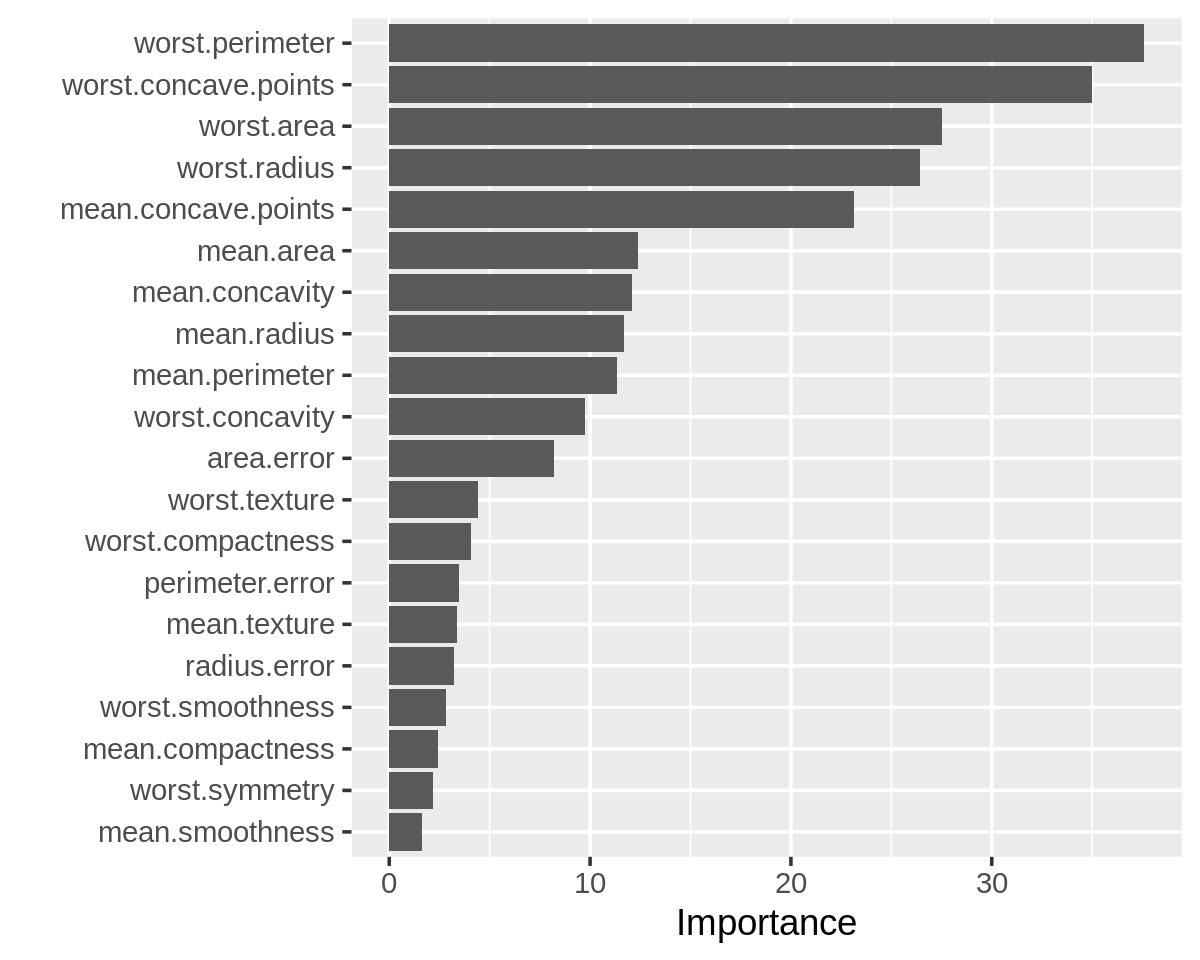

In [99]:
vip(model_rf,num_features = 20)

#<xml xmlns="https://developers.google.com/blockly/xml"><block type="dummyOutputCodeBlock_R" id="@nIf.I(F,$RV,eay2fk`" x="-211" y="-207"><field name="CODE">vip(model_rf,num_features = 20)</field></block></xml>

We can see that the "worst" versions of the following measures (the average of the 3 largest values)

- Radius
- Perimeter
- Area
- Concave points

are very important for detecting breast cancer.
As these are mostly measures of size (except concave points), that makes sense.

Interestingly, the "mean" versions are similar but just a bit less important.

<!-- No parallel in R except for parttree which only works for rpart and partykit, not ranger.

### Other visualizations

Other common options for visualization are visualizing each model in the ensemble (e.g. drawing the individual trees in the forest) or by looking at the *decision surface* of the ensemble.
The decision surface shows the regions in which the model classifies a datapoint into one class or another.
Consider this example from the `sklearn` documentation:

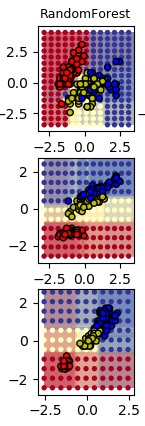 -->

<!-- This plot shows three decision surfaces for the `iris` dataset, which has three classes of iris, in three subplots:

- The top plot shows a forest's predictions using sepal width and the sepal length 
- The middle plot shows a forest's  predictions using petal length and sepal length
- The bottom plot shows a forest's predictions using petal width and the petal length

This kind of plot can be very useful for understanding the overall prediction behavior of an ensemble, but since the plots are 2D, only two predictors can be shown at a time, making it a bit unwieldy for high-dimensional datasets. -->